# Instrucciones Parte Computacional
## Tarea 5 ICS 3153 - Optimización Avanzada

En la pregunta 3 de su tarea se le pide implementar y comparar el rendimiento de 3 métodos en la resolución del problema de regresión robusta

$$
\min \left[ F ( x ) = \dfrac{1}{n} \sum _ { i = 1 } ^ { n } \left|\langle a_i, x \rangle - b_i\right| : \left|\left|x\right|\right|_1 \leq R \right] 
$$

Se provee de 6 datasets cuya solución óptima entrega un valor óptimo 0 para realizar la comparación de métodos pedida. Para esto utilizaremos la librería __json__.

In [1]:
import json

## Datasets: Carga y descripción

En primer lugar, se carga uno de los dataset. El archivo *datasetX.json* a cargar, correspondiente al dataset número X, debe encontrarse en la misma carpeta que el archivo de código o notebook donde se cargará. Ejemplificaremos con el primer dataset:

In [2]:
with open("dataset1.json") as rf:
    data = json.load(rf)

Una vez que el dataset ha sido cargado, toda la información necesaria para correr los métodos se encuentra en el diccionario *data*. Cada uno de los datasets posee los siguientes datos, los que pueden ser cargados y utilizados de manera análoga a *dataset1.json*.

En primer lugar, posee la cantidad (int) de observaciones $n$, la distancia máxima $R$ en el sentido $L_1$ (float) y la dimensión $d$ con que se trabaja en cada set de datos:

In [3]:
data["n"], data["R"], data["d"]

(7, 45.752057303901864, 1000)

En segundo lugar, posee las observaciones $a_i$ de las $d$ variables dependientes:

In [4]:
len(data["A"])

7

Para acceder a cada observación, se debe cambiar el índice $i$ de *data["A"]*[$i$]. Notamos que las observaciones corresponden a una lista de listas, donde cada observación es una lista de floats.

In [5]:
data["A"][0]

[0.00034095929484052623,
 7.061267891352947e-05,
 -0.0024485184613383844,
 0.0004620113062728358,
 -0.00020203118613288393,
 0.0006971976611465843,
 0.0001269496423826959,
 0.0007537642642345443,
 0.0002292549114280997,
 0.0007444188370933776,
 -0.0025145990825808217,
 -0.0015110494453017115,
 0.0017171684428382186,
 0.0008499868749734687,
 0.0007470901075908288,
 0.0010414083504453446,
 0.00028654095845340264,
 -0.0003432811090464337,
 0.000838258484726808,
 0.0011075013182708995,
 -0.0004892232649122989,
 7.100594185918012e-06,
 -0.00043470035849297857,
 -0.0011355212773907248,
 0.0011630365766970375,
 0.0004671739204857285,
 0.00013815439132444738,
 -0.0012954969926853633,
 0.0006321073838164616,
 0.0003069620643845842,
 -0.0007304536965950451,
 0.001374612858752045,
 0.0011650536972439686,
 0.0003611058389258042,
 -0.0003818990940474488,
 0.0006756974834036392,
 0.0004617578215808015,
 -0.00010027166364381087,
 -0.0006848454762007587,
 -0.0009649597884988338,
 -9.596242510013772e-0

In [6]:
len(data["A"][0])

1000

Por último, se tienen las $n$ observaciones de la variable independiente $b_i$:

In [7]:
data["B"][0], len(data["B"])

(-0.011699581684856413, 7)

Las $n$ observaciones también están en un formato de lista de floats.

## Implementación

Usted debe implementar los 3 métodos indicados en el enunciado, realizando comparaciones en el número de datos, el número de iteraciones y qué tan buena es su aproximación al valor óptimo.

### Recomendaciones

* Considere incluir gráficos en su análisis comparativo.

* Se recomienda la utilización de estructuras np.array en vez de listas para acelerar sus implementaciones.

* Para la medición del tiempo, se recomienda usar una librería como __time__ o __datetime__. Puede incluirlas en su código como se muestra en https://pythonhow.com/measure-execution-time-python-code/

In [8]:
#Ahora comenzaremos con la implementacion de los diferentes metodos

#Primero cargaremos todas las librerias a utilizar

import matplotlib.pyplot as plt
import numpy as np
import math
from numpy import linalg as LA
from numpy.linalg import inv
import time

In [9]:
#Ahora implementaremos la función gradiente que la utilizaremos en todos los algoritmos

#INPUT: Vector array, dimension 'd', numero de datos 'n', matriz 'A', vector 'B'
#OUTPUT: Vector array

def gradiente(x, d, n, A, B):
    suma=[]
    for k in range(d):
        suma.append(0)
    suma=np.array(suma)
    for i in range(n):
        suma=suma+np.sign(np.dot(x.T,A[i])-B[i])*np.array(A[i])
    suma=suma/n
    return suma

In [10]:
#También implementaremos la función F(x) que evalua nuestra función objetivo en un punto x cualquiera
#Esta función también se utilizará en todos los algoritmos

#INPUT: Vector array, dimension 'd', numero de datos 'n', matriz 'A', vector 'B'
#OUTPUT: Vector array

def F(x, d, n, A, B):
    suma=0
    for i in range(n):
        suma=suma+np.abs(np.dot(x.T,A[i])-B[i])
    suma=suma/n
    return suma

In [11]:
#Otra función importante es la de proyección sobre una bola de norma 1, radio R y centro 0

#INPUT: Vector array 'x', nivel de toleracia 'tol', radio 'R'
#OUTPUT: Vector array proyectado sobre la bola de norma 1, radio R y centro 0

def oraculo_de_proyeccion(x,tol,R):
    y= LA.norm(x,1)
    if y <= R:
        return x
    else:
        d=len(x)
        lista=[]
        for i in range(d):
            lista.append(abs(float(x[i])))
        a=0
        b=2*max(lista)
        p_a=0
        p_b=0
        l_ideal=-5
        for k in range(d):
            u_a=max((abs(float(x[k]))-a/2),0)
            u_b=max((abs(float(x[k]))-b/2),0)
            p_a = p_a + u_a
            p_b = p_b + u_b
        p_a = p_a - R
        p_b = p_b - R
        if p_a ==0:
            l_ideal=a
        if p_b==0:
            l_ideal=b
        else:
            error=LA.norm(x,1)-R
            c = (a+b)/2
            while error>tol:
                f_c = 0
                f_a = 0
                f_b = 0
                for j in range(d):
                    t_c = max((abs(float(x[j]))-c/2),0)
                    t_a = max((abs(float(x[j]))-a/2),0)
                    t_b = max((abs(float(x[j]))-b/2),0)
                    f_c=f_c+t_c
                    f_a=f_a+t_a
                    f_b=f_b+t_b
                f_c = f_c-R
                f_a = f_a-R
                f_b = f_b-R
                if f_c == 0:
                    l_ideal=c
                if f_c > 0:
                    a=c
                if f_c < 0:
                    b=c
                error=abs(f_c)
            l_ideal=c
        lista_final=[]
        for w in range(d):
            lista_final.append(max((2*abs(float(x[w])) - l_ideal)/2,0))
        lista_x=[]
        for e in range(d):
            lista_x.append((lista_final[e]*np.sign(float(x[e]))))
        lista_x = np.array(lista_x)
    return lista_x

In [22]:
#Implementaremos el gradiente proyectado

#INPUT: Numero de iteraciones 'T', nivel de toleracia 'tol' y radio a utilizar 'R', dimensión de los vector 'd', numero de 
# datos 'n'. También todos los datos A y B.

#OUTPUT: Valor de la función evaluada en el promedio hasta el momento en cada iteración, minimo de la funcion objetivo entre 
# todos los puntos x^k del algoritmo. Tiempo que se demora en correr el algoritmo.

# R = data["R"]
# d = data["d"]
# n = data["n"]
# A = data["A"]
# B = data["B"]

def proyected_gradient(T,tol,R,d,n,A,B):
    
    #--------------------------------
    
    #Calculo del vector inicial
    
    x_0=np.zeros(d)
    
    #---------------------------------
    
    #Ahora calculamos el valor de la constante de Lipschitz L
    
    L=0
    for k1 in range(n):
        L=L+LA.norm(np.array(A[k1]))
    L=L/n
    
    #---------------------------------
    
    #Ahora calcularemos el eta_t=eta (será constante)
    
    eta=R/(L*np.sqrt(T))
    
    #---------------------------------
    
    #Nuestro primer x es x_0
    
    x=x_0
    
    #---------------------------------
    
    #Ahora empezaremos a guardar nuestros valores de x
    
    lista_x=[]
    
    lista_x.append(x)
    
    #----------------------------------
    
    #Ahora comenzaremos a guardar nuestros valores de F
    
    lista_f=[]
    
    lista_f.append(F(x, d, n, A, B))
    
    #----------------------------------
    
    #Comenzaremos a guardar el tiempo que se demora en iterar
    
    t=time.perf_counter()
    
    lista_de_t=[]
    lista_de_t.append(0)
    
    #----------------------------------
    
    #Ahora comenzamos a iterar
    
    for i in range(T):
        x=x-eta*gradiente(x, d, n, A, B)
        x=oraculo_de_proyeccion(x,tol,R)
        
        lista_x.append(x)
        lista_f.append(F(x, d, n, A, B))
        
        t_1 = time.perf_counter()
        
        lista_de_t.append(t_1-t)
    
    #Ahora lo que haremos será encontrar el vector promedio hasta el momento para cada iteración
    
    lista_x_p=[]
    
    #También encontraremos la función promedio para cada iteracion
    
    lista_f_p=[]
    lista_best=[]
    lista_best_p=[]
    
    for j in range(len(lista_x)):
        x_p=x_0
        for h in range(j+1):
            x_p=x_p+lista_x[h]
        x_p=x_p/(j+1)
        lista_x_p.append(x_p)
        lista_f_p.append(F(x_p, d, n, A, B))
        best_x=lista_f[0:j+1]
        lista_best.append(min(best_x))
        best_x_p=lista_f_p[0:j+1]
        lista_best_p.append(min(best_x_p))
        
        
    #De esta forma es claro que el output promedio del algoritmo será:
    
    x_f=lista_x_p[len(lista_x_p)-1]
    
    # También es bueno decir en que iteración se alcanzo el minimo de los promedios y en que iteración se alcanzo el mínimo
    # de de la función minimo de f(x^k)
    
    T1=lista_f.index(lista_best[len(lista_best)-1])
    
    T2=lista_f_p.index(lista_best_p[len(lista_best_p)-1])
    
    #Ahora tiraremos el output
    
    lista=[]
    lista.append(x_f)
    lista.append(lista_x)
    lista.append(lista_f)
    lista.append(lista_x_p)
    lista.append(lista_f_p)
    lista.append(lista_best)
    lista.append(lista_best_p)
    lista.append(T1)
    lista.append(T2)
    lista.append(lista_de_t)
    
    return lista

In [13]:
# Ahora comenzaremos a implementar el método de mirror descense con la función phi propuesta

# Primero que todo, cuando utilizamos mirror descense debemos utilizar un oraculo que resuelve el problema cuando lambda es 
# distinto de cero

#Ahora calcularemos el oraculo para mirror descense

#INPUT: Vector 'v', valor de paso 'eta', radio 'R', cantidad de iteraciones a realizar 'M', dimension 'd'

#OUTPUT: Vector resultante

def oraculo_mirror_descense(v, eta, R, M, d):
    h=[]
    for k in range(d):
        h.append(np.abs(v[k]))
    b=max(h)
    a=0
    c=(a+b)/2
    for i in range(M):
        f_c=0
        for j in range(d):
            f_c=f_c+((max(np.abs(v[j])-c,0))*(eta/(np.exp(1)*np.log(d))))**(np.log(d))
        f_c=f_c-R
        if f_c>0:
            a=c
        if f_c<0:
            b=c
    
    vector_f=[]
    for t1 in range(d):
        vector_f.append(-((np.sign(v[t1]))*(((np.abs(v[t1]))*(eta/(np.exp(1)*np.log(d))))**(np.log(d)))))
    vector_f=np.array(vector_f)
    return vector_f

In [14]:
# Tambien necesitamos saber cual es el gradiente de Phi

def phi_gradient(x, d):
    gradient=[]
    for i in range(len(x)):
        gradient.append(np.exp(1)*np.log(d)*(abs(x[i])**(1/np.log(d)))*np.sign(x[i]))
    gradient=np.array(gradient)
    return gradient

In [15]:
# Ahora implementamos mirror descense

# INPUT: Numero de iteraciones

# R = data["R"]
# d = data["d"]
# n = data["n"]
# A = data["A"]
# B = data["B"]

# def proyected_gradient(T,tol,R,d,n,A,B):


def mirror_descense(T, R, d, n, A, B):
    
    #Primero hay que calcular el vector inicial que será 0
    
    x_0=np.zeros(d)
    
    #Comenzar a asignar valores para x
    
    x=x_0
    
    # Calulamos el valor de la constante de Lipschitz
    
    L=0
    for k1 in range(n):
        L=L+LA.norm(np.array(A[k1]))
    L=L/n
    
    #---------------------------------
    
    #Comienzo a guardar los valores de x
    
    lista_x=[]
    lista_x.append(x)
    
    #Comenzamos a guardar los valores de la función
    
    lista_f=[]
    lista_f.append(F(x, d, n, A, B))
    
    #Ahora vamos a determinar un eta constante en cada iteración
    
    eta=(np.sqrt(2)/(L*np.sqrt(T)))*np.sqrt((np.exp(1)*np.log(d)*(R**(1+1/np.log(d))))/(1+1/np.log(d)))
    
    #Comenzaremos a guardar el tiempo que se demora en iterar
    
    t=time.perf_counter()
    
    lista_de_t=[]
    lista_de_t.append(0)
    
    for i in range(T):
        v=gradiente(x, d, n, A, B)-(1/eta)*phi_gradient(x, d)
        u=[]
        for j in range(d):
            u.append(-(np.sign(v[j]))*((((eta)/(np.exp(1)*np.log(d)))*np.abs(v[j]))**(np.log(d))))
        u=np.array(u)
        
        if LA.norm(u,1)<=R:
            x=u
            lista_x.append(x)
            lista_f.append(F(x, d, n, A, B))
        else:
            M=20
            x=oraculo_mirror_descense(v, eta, R, M, d)
        t1=time.perf_counter()
        lista_de_t.append(t1-t)
            
    lista_x_p=[]
    lista_f_p=[]
    lista_best=[]
    lista_best_p=[]
    
    for h1 in range(len(lista_x)):
        contador=np.zeros(d)
        for h2 in range(h1+1):
            contador=contador+lista_x[h2]
        contador=contador/(h2+1)
        lista_x_p.append(contador)
        lista_f_p.append(F(contador, d, n, A, B))
        lista_best.append(min(lista_f[0:h1+1]))
        lista_best_p.append(min(lista_f_p[0:h1+1]))
    
    T1=lista_f.index(lista_best[len(lista_best)-1])
    
    T2=lista_f_p.index(lista_best_p[len(lista_best_p)-1])
    
    lista=[]
    lista.append(lista_x[len(lista_x)-1])
    lista.append(lista_x)
    lista.append(lista_f)
    lista.append(lista_x_p)
    lista.append(lista_f_p)
    lista.append(lista_best)
    lista.append(lista_best_p)
    lista.append(T1)
    lista.append(T2)
    lista.append(lista_de_t)
    
    return lista

In [16]:
# Ahora comenzaremos la implementación del algoritmo de los pesos multiplicativos y para esto primero debemos implementar 
# la función H

# La funcion H(y) que evalua F en x = y+,y-

def H(y, d, n, A, B):
    k=len(y)
    k1=int(k/2)
    
    x=[]
    
    for j in range(k1):
        x.append(y[j]-y[j+k1])
        
    x=np.array(x)
    
    p=F(x, d, n, A, B)
    return p

In [17]:
# También es necesario implementar el gradiente de H que por cierto es 2*d dimensional

def gradiente_H(y, d, n, A, B):
    
    #Vector debe ser de 2d

    suma=[]
    for k in range(2*d):
        suma.append(0)
    suma=np.array(suma)
    
    ###################
    
    # Ahora creamos a los nuevos vectores a utilizar concatenando a_i y -a_i
    
    W=[]
    
    for k1 in range(n):
        u=[]
        for k2 in range(d):
            u.append((A[k1])[k2])
        for k3 in range(d):
            u.append(-((A[k1])[k3]))
        u=np.array(u)
        W.append(u)
    
    ################
    
    # Ahora construiremos x a partir de y+,y-
    
    x=[]
    
    for k4 in range(d):
        q=y[k4]-y[k4+d]
        x.append(q)
    
    x=np.array(x)
    
    for i in range(n):
        suma=suma+np.sign(np.dot(x.T,A[i])-B[i])*W[i]
    suma=suma/n
    return suma

In [18]:
# Ahora programaremos el algoritmo de los pesos multiplicativos

def pesos_multiplicativos(T, R, d, n, A, B):
    
    #Partiremos construyendo nuestro y_0
    
    y_0=[]
    for k in range(2*d):
        y_0.append(1/(2*d))
    y_0=np.array(y_0)
    
    #Ahora comenzaremos a asignar valores a 'y'
    
    y=y_0
    
    #Calculamos nuestra constante de Lipschitz
    
    L1=0
    for k in range(n):
        L1=L1+(np.sqrt(2)/n)*LA.norm(A[k])
    
    #Ahora definimos nuestro eta_t=eta
    
    eta=R/(L1*np.sqrt(T))
    
    #Ahora lo que debemos hacer es comenzar a guardar los valores de y
    
    lista_y=[]
    lista_y.append(y)
    
    lista_f=[]
    
    lista_f.append(H(y, d, n, A, B))
    
    #Ahora comenzamos las iteraciones 
    
    t=time.perf_counter()
    
    lista_de_t=[]
    lista_de_t.append(0)
    
    for i in range(T):
        p=[]
        cant=0
        gH=gradiente_H(y, d, n, A, B)
        for j1 in range(2*d):
            cant=cant+y[j1]*np.exp(-eta*((gH)[j1]))
        for j in range(2*d):
            p.append(((y[j]*np.exp(-eta*((gH)[j])))))
        p=np.array(p)
        
        y=p
        
        lista_y.append(y)
        
        lista_f.append(H(y, d, n, A, B))
        
        t1=time.perf_counter()
        lista_de_t.append(t1-t)
    
    #Ahora lo que haremos será calcular los valores promedios de y
    
    lista_y_p=[]
    
    lista_f_p=[]
    
    lista_best=[]
    
    lista_best_p=[]

    for l7 in range(len(lista_y)):
        prom=np.zeros(2*d)
        for l8 in range(l7+1):
            prom=prom+lista_y[l8]
        prom=prom/(l7+1)
        lista_y_p.append(prom)
        lista_f_p.append(H(prom, d, n, A, B))
        lista_best.append(min(lista_f[0:l7+1]))
        lista_best_p.append(min(lista_f_p[0:l7+1]))
    
    
    #De esta forma es claro que el output promedio del algoritmo será:
    
    y_f=lista_y_p[len(lista_y_p)-1]
    
    T1=lista_f.index(lista_best[len(lista_best)-1])
    
    T2=lista_f_p.index(lista_best_p[len(lista_best_p)-1])
    
    #Ahora tiraremos el output
    
    lista=[]
    lista.append(y_f)
    lista.append(lista_y)
    lista.append(lista_f)
    lista.append(lista_y_p)
    lista.append(lista_f_p)
    lista.append(lista_best)
    lista.append(lista_best_p)
    lista.append(T1)
    lista.append(T2)
    lista.append(lista_de_t)
    
    return lista

In [19]:
# CARGAR LOS DATASETS

#DATASET 1

with open("dataset1.json") as rf:
    data1 = json.load(rf)

R1 = data1["R"]
d1 = data1["d"]
n1 = data1["n"]
A1 = data1["A"]
B1 = data1["B"]
    
#DATASET 2
    
with open("dataset2.json") as rf:
    data2 = json.load(rf)

R2 = data2["R"]
d2 = data2["d"]
n2 = data2["n"]
A2 = data2["A"]
B2 = data2["B"]    

#DATASET 3
    
with open("dataset3.json") as rf:
    data3 = json.load(rf)

R3 = data3["R"]
d3 = data3["d"]
n3 = data3["n"]
A3 = data3["A"]
B3 = data3["B"] 

#DATASET 4
    
with open("dataset4.json") as rf:
    data4 = json.load(rf)

R4 = data4["R"]
d4 = data4["d"]
n4 = data4["n"]
A4 = data4["A"]
B4 = data4["B"] 

#DATASET 5
    
with open("dataset5.json") as rf:
    data5 = json.load(rf)

R5 = data5["R"]
d5 = data5["d"]
n5 = data5["n"]
A5 = data5["A"]
B5 = data5["B"] 

#DATASET 6
    
with open("dataset6.json") as rf:
    data6 = json.load(rf)
    
R6 = data6["R"]
d6 = data6["d"]
n6 = data6["n"]
A6 = data6["A"]
B6 = data6["B"] 

In [23]:
#Ahora mostraremos un par de datos que serán importantes para nosotros

print(R1)
print(R2)
print(R3)
print(R4)
print(R5)
print(R6)

print("-------------")

print(n1)
print(n2)
print(n3)
print(n4)
print(n5)
print(n6)

print("-------------")

print(d1)
print(d2)
print(d3)
print(d4)
print(d5)
print(d6)

45.752057303901864
89.12404191785463
157.2577366631856
83.25354212966926
91.30912954047062
84.84752733176582
-------------
7
12
22
1000
1000
1000
-------------
1000
1000
1000
1000
1000
1000


In [24]:
#DATASET 1

#Graficaremos los 3 metodos al mismo tiempo. 

#Primero graficaremos el valor de la función objetivo en funcion de las iteraciones
#Segundo graficaremos el tiempo que se demoran en ejecutar en función de las iteraciones

#Primero debemos decir que número de iteraciones debemos tener y que nivel de tolerancia

T=1000
tol=10**(-3)

pg1=proyected_gradient(T,tol,R1,d1,n1,A1,B1)
md1=mirror_descense(T,R1,d1,n1,A1,B1)
pm1=pesos_multiplicativos(T,R1,d1,n1,A1,B1)

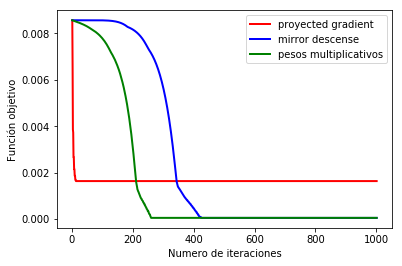

In [25]:
#Graficamos en ESCALA NORMAL

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg1[6],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md1[5],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm1[5],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.legend(loc='best')
plt.show()


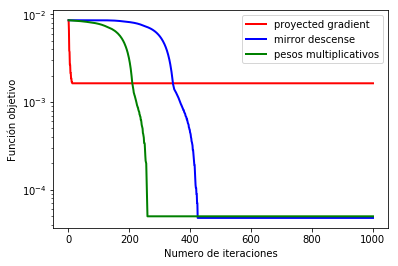

In [26]:
#Ahora graficamos en ESCALA LOGARITMICA

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg1[6],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md1[5],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm1[5],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

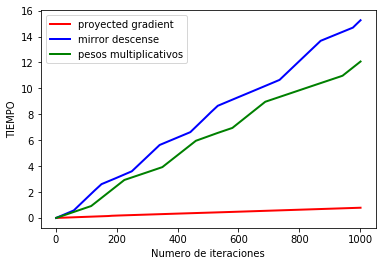

In [27]:
# Ahora graficaremos el tiempo que se demoran en iterar los algoritmos

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg1[9],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md1[9],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm1[9],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('TIEMPO')
plt.legend(loc='best')
plt.show()

In [28]:
#DATASET 2

#Graficaremos los 3 metodos al mismo tiempo. 

#Primero graficaremos el valor de la función objetivo en funcion de las iteraciones
#Segundo graficaremos el tiempo que se demoran en ejecutar en función de las iteraciones

#Primero debemos decir que número de iteraciones debemos tener y que nivel de tolerancia

T=1000
tol=10**(-3)

pg2=proyected_gradient(T,tol,R2,d2,n2,A2,B2)
md2=mirror_descense(T,R2,d2,n2,A2,B2)
pm2=pesos_multiplicativos(T,R2,d2,n2,A2,B2)

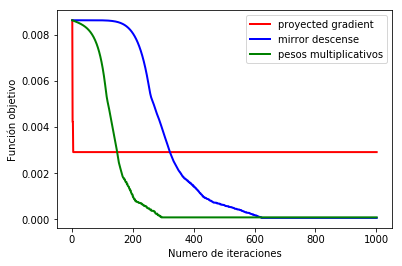

In [29]:
#Graficamos en ESCALA NORMAL

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg2[5],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md2[5],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm2[5],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.legend(loc='best')
plt.show()


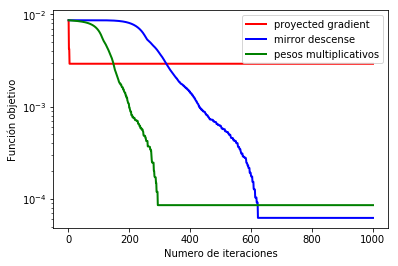

In [30]:
#Ahora graficamos en ESCALA LOGARITMICA

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg2[5],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md2[5],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm2[5],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

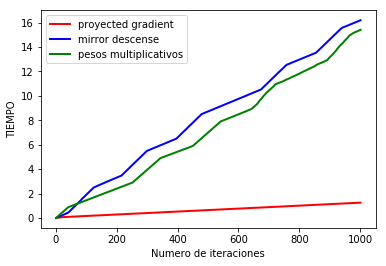

In [31]:
# Ahora graficaremos el tiempo que se demoran en iterar los algoritmos

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg2[9],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md2[9],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm2[9],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('TIEMPO')
plt.legend(loc='best')
plt.show()

In [32]:
#DATASET 3

#Graficaremos los 3 metodos al mismo tiempo. 

#Primero graficaremos el valor de la función objetivo en funcion de las iteraciones
#Segundo graficaremos el tiempo que se demoran en ejecutar en función de las iteraciones

#Primero debemos decir que número de iteraciones debemos tener y que nivel de tolerancia

T=1000
tol=10**(-3)

pg3=proyected_gradient(T,tol,R3,d3,n3,A3,B3)
md3=mirror_descense(T,R3,d3,n3,A3,B3)
pm3=pesos_multiplicativos(T,R3,d3,n3,A3,B3)

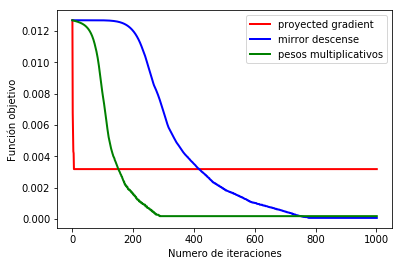

In [33]:
#Graficamos en ESCALA NORMAL

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg3[5],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md3[5],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm3[5],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.legend(loc='best')
plt.show()

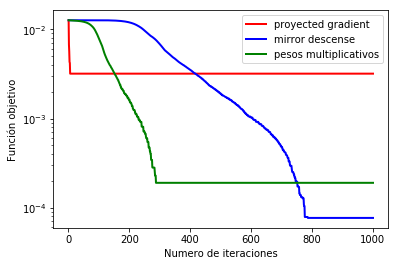

In [34]:
#Ahora graficamos en ESCALA LOGARITMICA

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg3[5],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md3[5],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm3[5],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

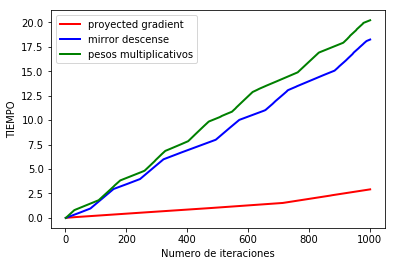

In [35]:
# Ahora graficaremos el tiempo que se demoran en iterar los algoritmos

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg3[9],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md3[9],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm3[9],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('TIEMPO')
plt.legend(loc='best')
plt.show()

In [36]:
#DATASET 4

#Graficaremos los 3 metodos al mismo tiempo. 

#Primero graficaremos el valor de la función objetivo en funcion de las iteraciones
#Segundo graficaremos el tiempo que se demoran en ejecutar en función de las iteraciones

#Primero debemos decir que número de iteraciones debemos tener y que nivel de tolerancia

T=50
tol=10**(1)


pg4=proyected_gradient(T,tol,R4,d4,n4,A4,B4)
md4=mirror_descense(T,R4,d4,n4,A4,B4)
pm4=pesos_multiplicativos(T,R4,d4,n4,A4,B4)

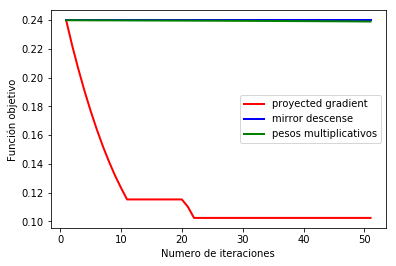

In [37]:
#Graficamos en ESCALA NORMAL

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg4[5],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md4[5],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm4[5],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.legend(loc='best')
plt.show()

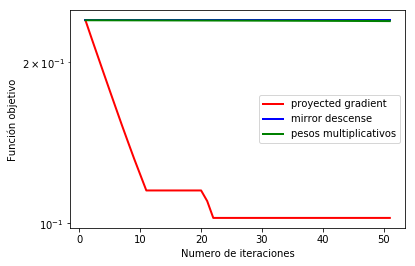

In [38]:
#Ahora graficamos en ESCALA LOGARITMICA

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg4[5],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md4[5],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm4[5],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

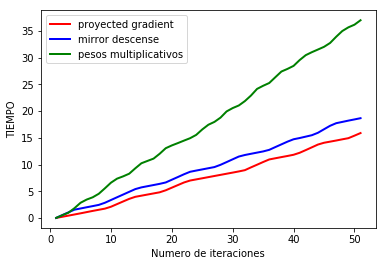

In [39]:
# Ahora graficaremos el tiempo que se demoran en iterar los algoritmos

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg4[9],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md4[9],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm4[9],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('TIEMPO')
plt.legend(loc='best')
plt.show()

In [40]:
#DATASET 5

#Graficaremos los 3 metodos al mismo tiempo. 

#Primero graficaremos el valor de la función objetivo en funcion de las iteraciones
#Segundo graficaremos el tiempo que se demoran en ejecutar en función de las iteraciones

#Primero debemos decir que número de iteraciones debemos tener y que nivel de tolerancia

T=50
tol=10**(1)


pg5=proyected_gradient(T,tol,R5,d5,n5,A5,B5)
md5=mirror_descense(T,R5,d5,n5,A5,B5)
pm5=pesos_multiplicativos(T,R5,d5,n5,A5,B5)

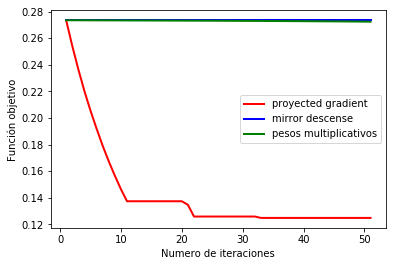

In [41]:
#Graficamos en ESCALA NORMAL

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg5[5],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md5[5],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm5[5],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.legend(loc='best')
plt.show()

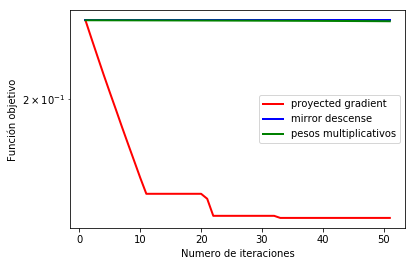

In [42]:
#Ahora graficamos en ESCALA LOGARITMICA

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg5[5],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md5[5],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm5[5],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

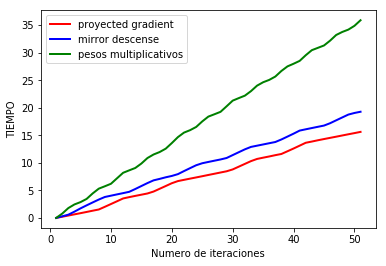

In [43]:
# Ahora graficaremos el tiempo que se demoran en iterar los algoritmos

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg5[9],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md5[9],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm5[9],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('TIEMPO')
plt.legend(loc='best')
plt.show()

In [44]:
#DATASET 6

#Graficaremos los 3 metodos al mismo tiempo. 

#Primero graficaremos el valor de la función objetivo en funcion de las iteraciones
#Segundo graficaremos el tiempo que se demoran en ejecutar en función de las iteraciones

#Primero debemos decir que número de iteraciones debemos tener y que nivel de tolerancia

T=50
tol=10**(1)


pg6=proyected_gradient(T,tol,R6,d6,n6,A6,B6)
md6=mirror_descense(T,R6,d6,n6,A6,B6)
pm6=pesos_multiplicativos(T,R6,d6,n6,A6,B6)

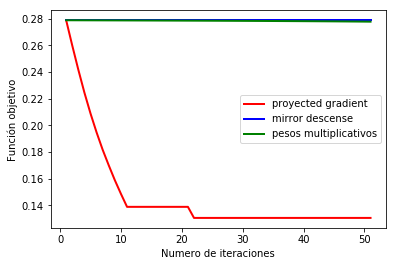

In [45]:
#Graficamos en ESCALA NORMAL

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg6[5],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md6[5],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm6[5],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.legend(loc='best')
plt.show()

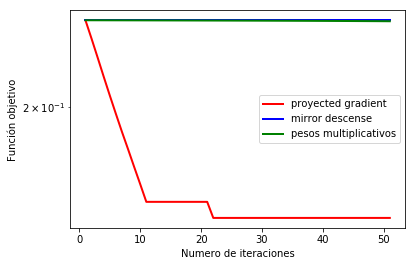

In [46]:
#Ahora graficamos en ESCALA LOGARITMICA

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg6[5],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md6[5],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm6[5],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

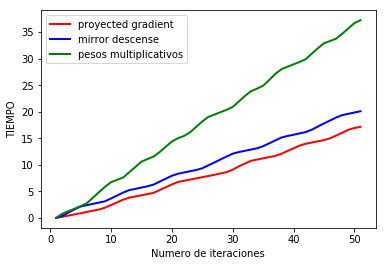

In [50]:
# Ahora graficaremos el tiempo que se demoran en iterar los algoritmos

#Creamos el vector para graficar el eje X

u=[]

for j in range(T+1):
    u.append(j+1)

plt.plot(u,pg6[9],color="red", linewidth=2, label='proyected gradient')
plt.plot(u,md6[9],color="blue", linewidth=2, label='mirror descense')
plt.plot(u,pm6[9],color="green", linewidth=2, label='pesos multiplicativos')

plt.xlabel('Numero de iteraciones')
plt.ylabel('TIEMPO')
plt.legend(loc='best')
plt.show()

In [48]:
###############################

#Ahora lo que haremos será graficar el mismo método para distintos datasets

##############################

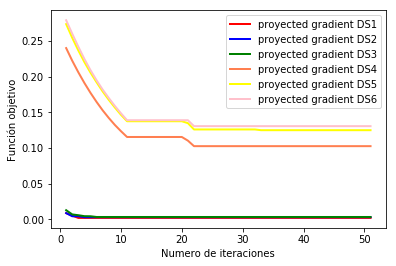

In [52]:
#GRADIENTE PROYECTADO

#Graficamos en ESCALA NORMAL

#Creamos el vector para graficar el eje X

u=[]

for j in range(51):
    u.append(j+1)

plt.plot(u,(pg1[5])[0:51],color="red", linewidth=2, label='proyected gradient DS1')
plt.plot(u,(pg2[5])[0:51],color="blue", linewidth=2, label='proyected gradient DS2')
plt.plot(u,(pg3[5])[0:51],color="green", linewidth=2, label='proyected gradient DS3')
plt.plot(u,pg4[5],color="coral", linewidth=2, label='proyected gradient DS4')
plt.plot(u,pg5[5],color="yellow", linewidth=2, label='proyected gradient DS5')
plt.plot(u,pg6[5],color="pink", linewidth=2, label='proyected gradient DS6')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.legend(loc='best')
plt.show()

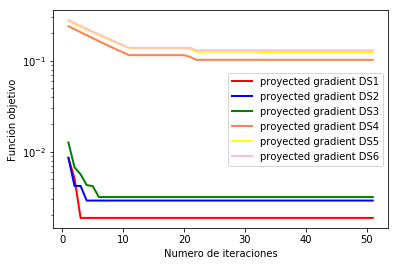

In [53]:
#Graficamos en ESCALA LOGARITMICA

#Creamos el vector para graficar el eje X

u=[]

for j in range(51):
    u.append(j+1)

plt.plot(u,(pg1[5])[0:51],color="red", linewidth=2, label='proyected gradient DS1')
plt.plot(u,(pg2[5])[0:51],color="blue", linewidth=2, label='proyected gradient DS2')
plt.plot(u,(pg3[5])[0:51],color="green", linewidth=2, label='proyected gradient DS3')
plt.plot(u,pg4[5],color="coral", linewidth=2, label='proyected gradient DS4')
plt.plot(u,pg5[5],color="yellow", linewidth=2, label='proyected gradient DS5')
plt.plot(u,pg6[5],color="pink", linewidth=2, label='proyected gradient DS6')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

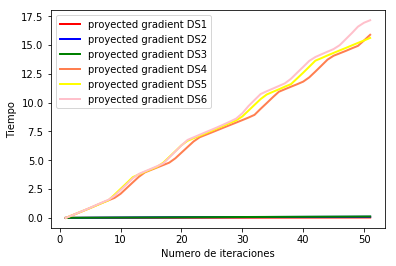

In [54]:
#Grafico del TIEMPO

#Creamos el vector para graficar el eje X

u=[]

for j in range(51):
    u.append(j+1)

plt.plot(u,(pg1[9])[0:51],color="red", linewidth=2, label='proyected gradient DS1')
plt.plot(u,(pg2[9])[0:51],color="blue", linewidth=2, label='proyected gradient DS2')
plt.plot(u,(pg3[9])[0:51],color="green", linewidth=2, label='proyected gradient DS3')
plt.plot(u,pg4[9],color="coral", linewidth=2, label='proyected gradient DS4')
plt.plot(u,pg5[9],color="yellow", linewidth=2, label='proyected gradient DS5')
plt.plot(u,pg6[9],color="pink", linewidth=2, label='proyected gradient DS6')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Tiempo')
plt.legend(loc='best')
plt.show()

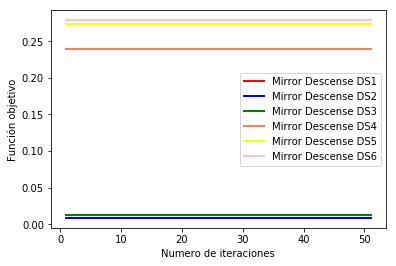

In [63]:
#MIRROR DESCENSE

#Graficamos en ESCALA NORMAL

#Creamos el vector para graficar el eje X

u=[]

for j in range(51):
    u.append(j+1)

plt.plot(u,(md1[5])[0:51],color="red", linewidth=2, label='Mirror Descense DS1')
plt.plot(u,(md2[5])[0:51],color="blue", linewidth=2, label='Mirror Descense DS2')
plt.plot(u,(md3[5])[0:51],color="green", linewidth=2, label='Mirror Descense DS3')
plt.plot(u,md4[5],color="coral", linewidth=2, label='Mirror Descense DS4')
plt.plot(u,md5[5],color="yellow", linewidth=2, label='Mirror Descense DS5')
plt.plot(u,md6[5],color="pink", linewidth=2, label='Mirror Descense DS6')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.legend(loc='best')
plt.show()

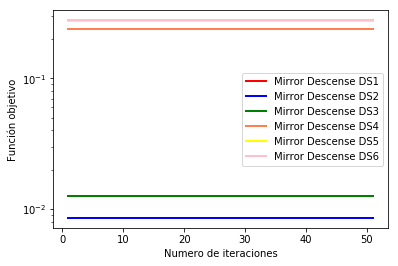

In [64]:
#Graficamos en ESCALA LOGARITMICA

#Creamos el vector para graficar el eje X

u=[]

for j in range(51):
    u.append(j+1)

plt.plot(u,(md1[5])[0:51],color="red", linewidth=2, label='Mirror Descense DS1')
plt.plot(u,(md2[5])[0:51],color="blue", linewidth=2, label='Mirror Descense DS2')
plt.plot(u,(md3[5])[0:51],color="green", linewidth=2, label='Mirror Descense DS3')
plt.plot(u,md4[5],color="coral", linewidth=2, label='Mirror Descense DS4')
plt.plot(u,md5[5],color="yellow", linewidth=2, label='Mirror Descense DS5')
plt.plot(u,md6[5],color="pink", linewidth=2, label='Mirror Descense DS6')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

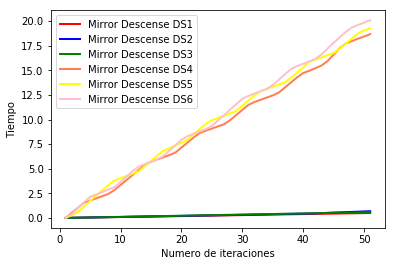

In [65]:
#Grafico del TIEMPO

#Creamos el vector para graficar el eje X

u=[]

for j in range(51):
    u.append(j+1)

plt.plot(u,(md1[9])[0:51],color="red", linewidth=2, label='Mirror Descense DS1')
plt.plot(u,(md2[9])[0:51],color="blue", linewidth=2, label='Mirror Descense DS2')
plt.plot(u,(md3[9])[0:51],color="green", linewidth=2, label='Mirror Descense DS3')
plt.plot(u,md4[9],color="coral", linewidth=2, label='Mirror Descense DS4')
plt.plot(u,md5[9],color="yellow", linewidth=2, label='Mirror Descense DS5')
plt.plot(u,md6[9],color="pink", linewidth=2, label='Mirror Descense DS6')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Tiempo')
plt.legend(loc='best')
plt.show()

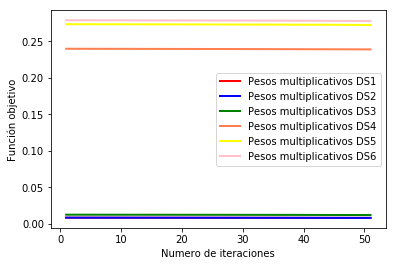

In [66]:
#PESOS MULTIPLICATIVOS

#Graficamos en ESCALA NORMAL

#Creamos el vector para graficar el eje X

u=[]

for j in range(51):
    u.append(j+1)

plt.plot(u,(pm1[5])[0:51],color="red", linewidth=2, label='Pesos multiplicativos DS1')
plt.plot(u,(pm2[5])[0:51],color="blue", linewidth=2, label='Pesos multiplicativos DS2')
plt.plot(u,(pm3[5])[0:51],color="green", linewidth=2, label='Pesos multiplicativos DS3')
plt.plot(u,pm4[5],color="coral", linewidth=2, label='Pesos multiplicativos DS4')
plt.plot(u,pm5[5],color="yellow", linewidth=2, label='Pesos multiplicativos DS5')
plt.plot(u,pm6[5],color="pink", linewidth=2, label='Pesos multiplicativos DS6')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.legend(loc='best')
plt.show()

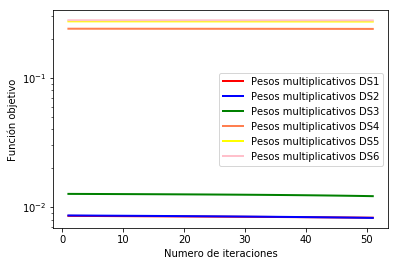

In [67]:
#PESOS MULTIPLICATIVOS

#Graficamos en ESCALA LOGARITMICA

#Creamos el vector para graficar el eje X

u=[]

for j in range(51):
    u.append(j+1)

plt.plot(u,(pm1[5])[0:51],color="red", linewidth=2, label='Pesos multiplicativos DS1')
plt.plot(u,(pm2[5])[0:51],color="blue", linewidth=2, label='Pesos multiplicativos DS2')
plt.plot(u,(pm3[5])[0:51],color="green", linewidth=2, label='Pesos multiplicativos DS3')
plt.plot(u,pm4[5],color="coral", linewidth=2, label='Pesos multiplicativos DS4')
plt.plot(u,pm5[5],color="yellow", linewidth=2, label='Pesos multiplicativos DS5')
plt.plot(u,pm6[5],color="pink", linewidth=2, label='Pesos multiplicativos DS6')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Función objetivo')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

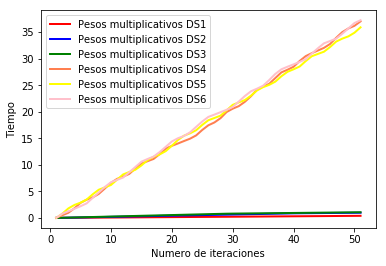

In [69]:
#PESOS MULTIPLICATIVOS

#Graficamos en TIEMPO

#Creamos el vector para graficar el eje X

u=[]

for j in range(51):
    u.append(j+1)

plt.plot(u,(pm1[9])[0:51],color="red", linewidth=2, label='Pesos multiplicativos DS1')
plt.plot(u,(pm2[9])[0:51],color="blue", linewidth=2, label='Pesos multiplicativos DS2')
plt.plot(u,(pm3[9])[0:51],color="green", linewidth=2, label='Pesos multiplicativos DS3')
plt.plot(u,pm4[9],color="coral", linewidth=2, label='Pesos multiplicativos DS4')
plt.plot(u,pm5[9],color="yellow", linewidth=2, label='Pesos multiplicativos DS5')
plt.plot(u,pm6[9],color="pink", linewidth=2, label='Pesos multiplicativos DS6')

plt.xlabel('Numero de iteraciones')
plt.ylabel('Tiempo')
plt.legend(loc='best')
plt.show()